<a href="https://colab.research.google.com/github/capofwesh20/Electric-Power-Consumption-Forecasting/blob/main/Electric_Power_Consumption_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The data used in this notebook comes from the [Kaggle's Electric Power Consumption dataset](https://https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption)

# Table of Content

1.   Importing/Loading & checking the data
2.   Data visualization 📊
3.   Data Preprocessing ⚙️
*   Handle Missings

4.   Feature engineering 🔧
5.   Exploratory Data Analysis 📊
6.   Modeling
7.   CNN model
*    LSTM
* Xgboost model
8.   Comparing models
9.   Conclusions

# I. Importing/Loading & checking the data:

In [ ]:
%%capture
!pip install tensorflow

In [ ]:
# Import packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.optimizers import Adam
from sklearn.metrics import r2_score

In [ ]:
# Load Dataset
df  = pd.read_csv("/content/powerconsumption.csv")

In [ ]:
df.head(10) #Show the first lines of the dataframe

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
5,1/1/2017 0:50,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048
6,1/1/2017 1:00,5.641,77.7,0.080,0.048,0.096,25998.98734,16993.31307,17945.06024
7,1/1/2017 1:10,5.496,78.2,0.085,0.055,0.093,25446.07595,16661.39818,17459.27711
8,1/1/2017 1:20,5.678,78.1,0.081,0.066,0.141,24777.72152,16227.35562,17025.54217
9,1/1/2017 1:30,5.491,77.3,0.082,0.062,0.111,24279.49367,15939.20973,16794.21687


# 2. Data visualization 📊

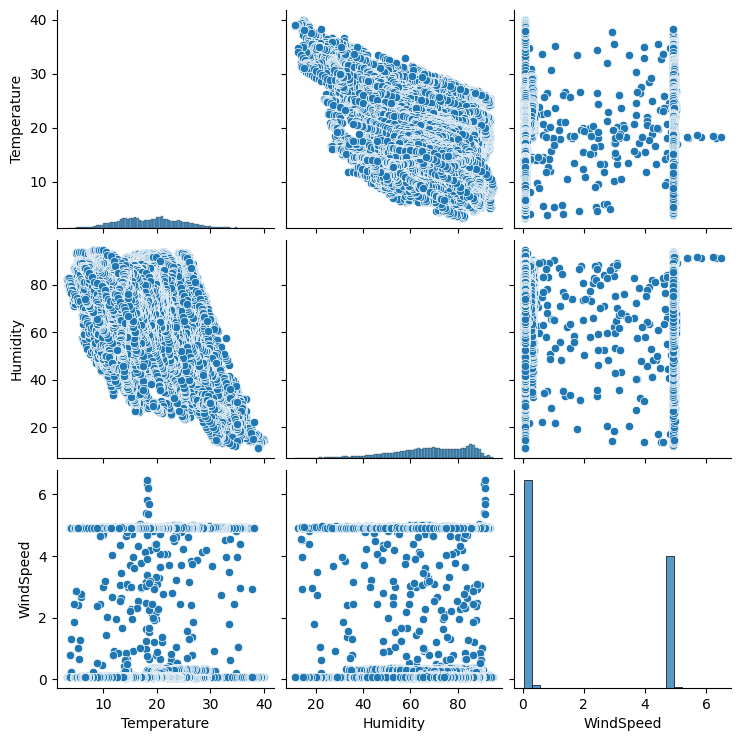

In [ ]:
# Pairplot to visualize relationships between numerical columns
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed']])
plt.show()

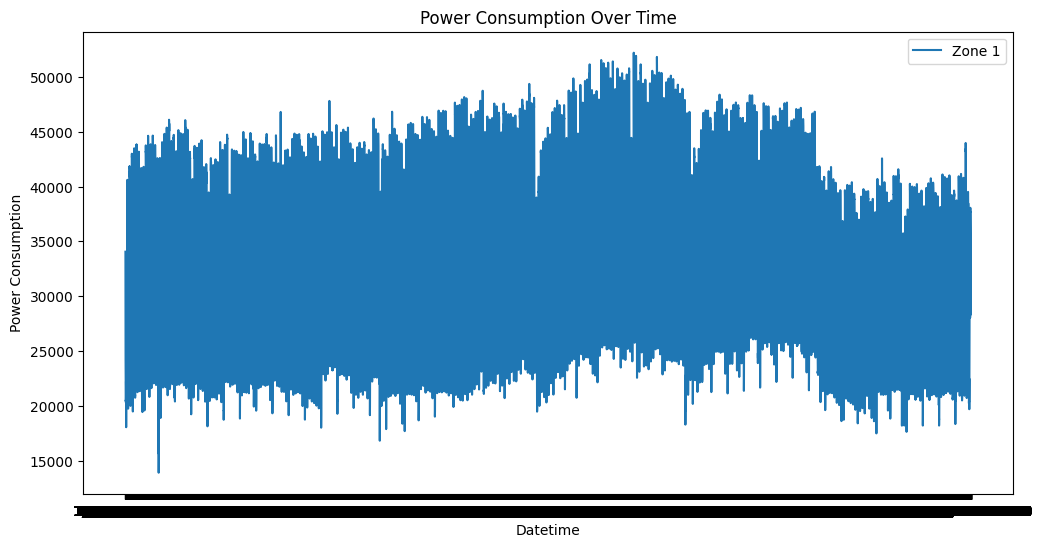

In [ ]:
# Time series plot for PowerConsumption
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

# 3. Data Preprocessing ⚙️

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [ ]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

In [ ]:
chronological_order, equidistant_timestamps

(True, True)

# Handle Missings Values

In [ ]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

# Feature Engineering

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))

    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)

    # Minute-level features
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']

    return df.astype(float)






In [ ]:
df = df.set_index('Datetime')
df = create_features(df)

In [ ]:
df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter', 'season']].head()

,year,month,day,minute,dayofyear,weekofyear,quarter,season
Datetime,,,,,,,,
2017-01-01 00:00:00,2017.0,1.0,1.0,0.0,1.0,52.0,1.0,1.0
2017-01-01 00:10:00,2017.0,1.0,1.0,10.0,1.0,52.0,1.0,1.0
2017-01-01 00:20:00,2017.0,1.0,1.0,20.0,1.0,52.0,1.0,1.0
2017-01-01 00:30:00,2017.0,1.0,1.0,30.0,1.0,52.0,1.0,1.0
2017-01-01 00:40:00,2017.0,1.0,1.0,40.0,1.0,52.0,1.0,1.0


#5. Exploratory Data Analysis 📊

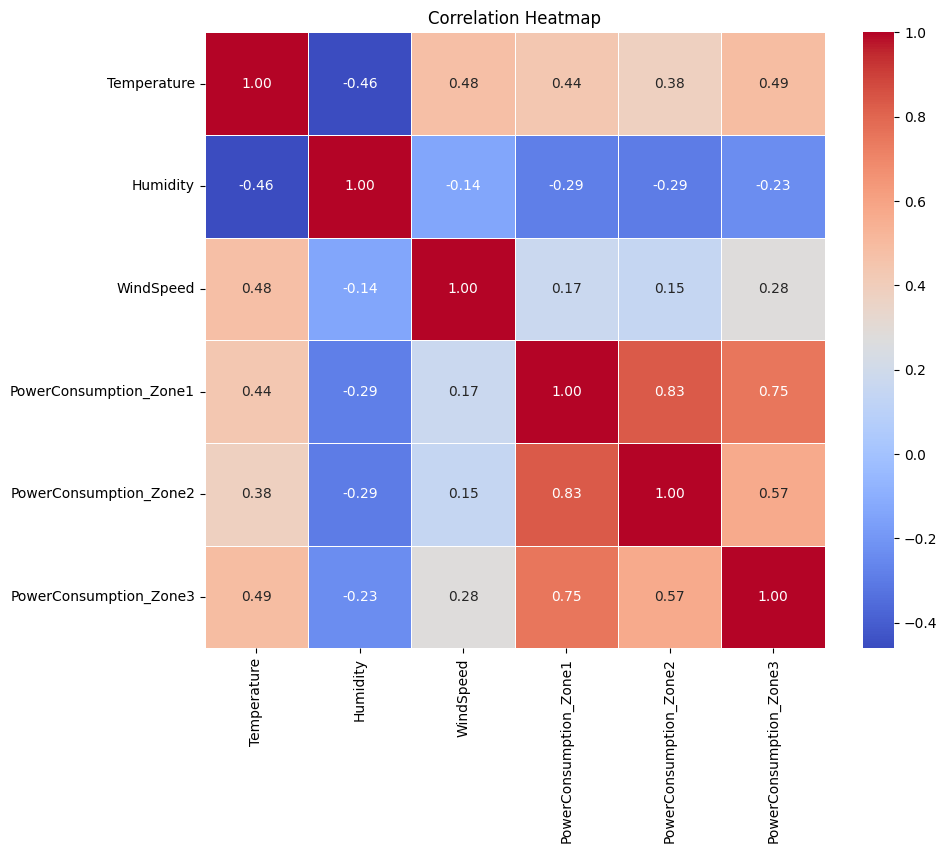

In [ ]:
# Calculate correlation matrix
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

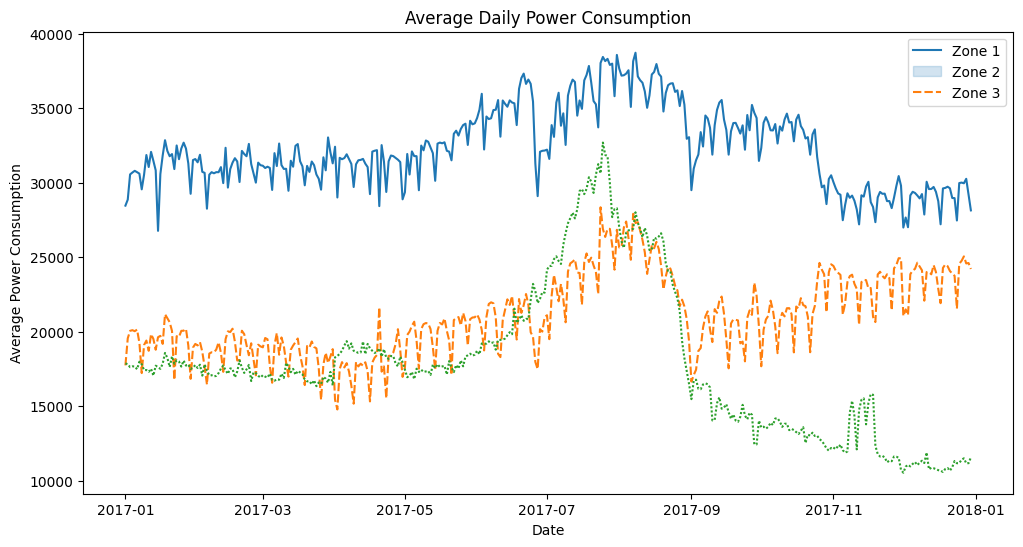

In [ ]:
# Resample the data for more meaningful time series analysis (e.g., daily, weekly)
daily_resampled = df.resample('D').mean()

# Plot daily Power Consumption for each zone
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

# 6. Modeling 🧩



In [ ]:
from sklearn.preprocessing import StandardScaler

# Separate the input features (X) and target variables (y)
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Initialize StandardScaler for y
scaler_y = StandardScaler()

# Fit and transform  y
y_scaled = scaler_y.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (39312, 26, 1)
Validation set shape (13104, 26, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(3))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 25, 64)            192       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 768)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                38450     
                                                                 
 dense_9 (Dense)             (None, 3)                 153       
                                                                 
Total params: 38795 (151.54 KB)
Trainable params: 38795 (151.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
cnn_history = model_cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 5s - loss: 9.3107 - val_loss: 1.4217 - 5s/epoch - 4ms/step
Epoch 2/40
1229/1229 - 4s - loss: 0.5345 - val_loss: 2.2769 - 4s/epoch - 3ms/step
Epoch 3/40
1229/1229 - 3s - loss: 0.5737 - val_loss: 0.9873 - 3s/epoch - 3ms/step
Epoch 4/40
1229/1229 - 4s - loss: 0.6140 - val_loss: 0.6349 - 4s/epoch - 3ms/step
Epoch 5/40
1229/1229 - 4s - loss: 0.5966 - val_loss: 0.3376 - 4s/epoch - 3ms/step
Epoch 6/40
1229/1229 - 6s - loss: 0.5515 - val_loss: 0.8894 - 6s/epoch - 5ms/step
Epoch 7/40
1229/1229 - 6s - loss: 0.5709 - val_loss: 1.5199 - 6s/epoch - 5ms/step
Epoch 8/40
1229/1229 - 4s - loss: 0.5330 - val_loss: 0.6845 - 4s/epoch - 4ms/step
Epoch 9/40
1229/1229 - 3s - loss: 0.5409 - val_loss: 0.5868 - 3s/epoch - 3ms/step
Epoch 10/40
1229/1229 - 4s - loss: 0.5231 - val_loss: 0.6986 - 4s/epoch - 4ms/step
Epoch 11/40
1229/1229 - 4s - loss: 0.5463 - val_loss: 0.4256 - 4s/epoch - 4ms/step
Epoch 12/40
1229/1229 - 4s - loss: 0.4982 - val_loss: 0.6566 - 4s/epoch - 3ms/step
Epoch 13/40
1

#  LSTM Model

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(3))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_10 (Dense)            (None, 3)                 153       
                                                                 
Total params: 10553 (41.22 KB)
Trainable params: 10553 (41.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Xgboost model

In [ ]:
!nvidia-smi


Wed Feb 21 01:48:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              50W / 400W |    537MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the hyperparameter grid for XGBoost, including the 'device':'cuda' setting
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [1000, 1500, 2000],
    'min_child_weight': [1, 2],
    'booster': ['gbtree'],
    'tree_method': ['hist'],  # Updated as per the new guidelines
    'device': ['cuda']  # Ensure we're specifying to use CUDA
}

# Create the XGBoost model object with the updated parameters
xgb_model = xgb.XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)


# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error on test set:", mse)
print("Mean absolute error on test set:", mae)


Best set of hyperparameters: {'booster': 'gbtree', 'colsample_bytree': 0.7, 'device': 'cuda', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'subsample': 0.7, 'tree_method': 'hist'}
Best score: -0.3871654705583019
Mean squared error on test set: 0.2616242043665727
Mean absolute error on test set: 0.40951494282869416


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the hyperparameter grid for XGBoost, including the 'device':'cuda' setting
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [1000, 1500, 2000],
    'min_child_weight': [1, 2],
    'booster': ['gbtree'],
    'tree_method': ['hist'],  # Updated as per the new guidelines
    'device': ['cuda']  # Ensure we're specifying to use CUDA
}

# Create the XGBoost model object with the updated parameters
xgb_model = xgb.XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error on test set:", mse)
print("Mean absolute error on test set:", mae)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
model =  grid_search.best_estimator_

In [ ]:
xgboost_history = model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=200)

In [ ]:
# Lets predict with the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

In [ ]:
# Feature Importances
_ = plot_importance(model, height=0.9)

#  Comparing models

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]


ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(xgboost_history.history['loss'], label='Train loss')
ax3.plot(xgboost_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('Xgboost')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')
plt.show()